In [1]:
# import matplotlib
# print(matplotlib.__version__)

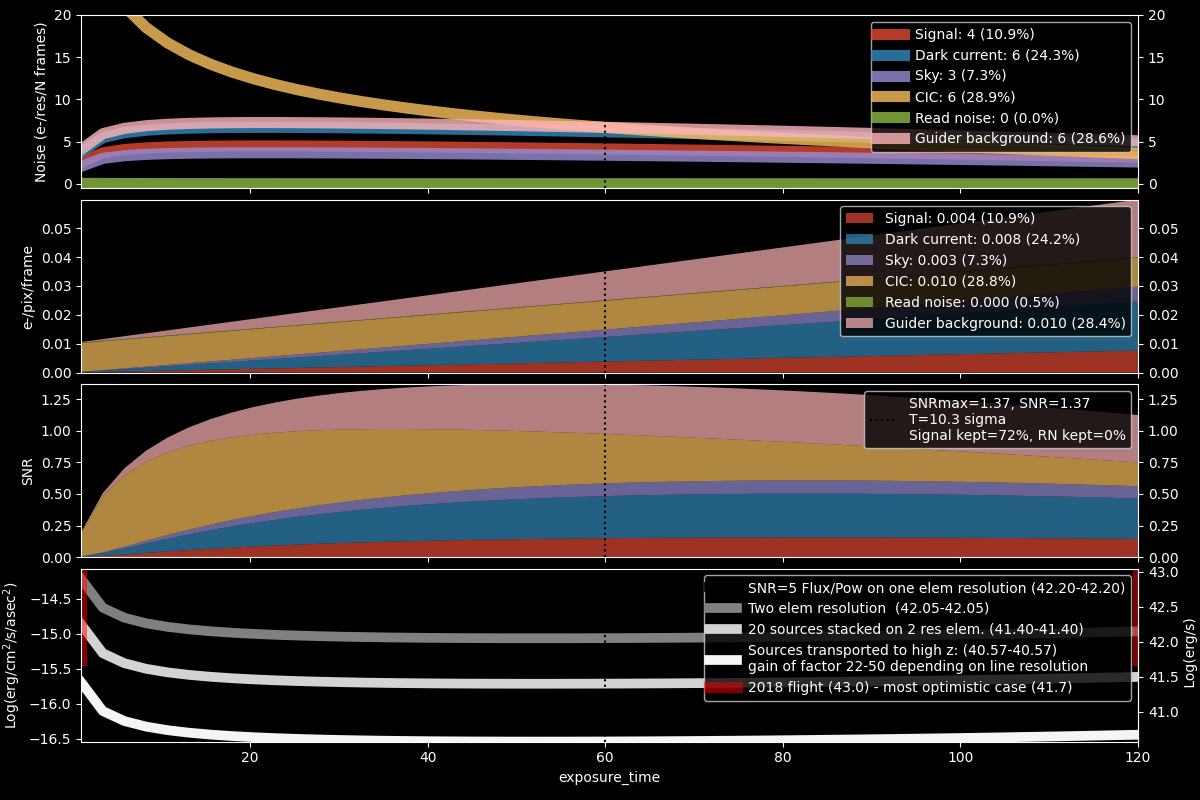

In [1]:
%matplotlib widget
%reload_ext autoreload
# changes must only occure on ETC_FB2.ipynb! Chages are then copied on ETC.ipynb!

from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox
from astropy.modeling.functional_models import Gaussian2D, Gaussian1D

from IPython.display import display, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import inspect
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from functools import wraps
import inspect
from scipy.sparse import dia_matrix
from scipy.interpolate import interpn
# plt.style.use('dark_background')
import functools
np.seterr(invalid='ignore')

# import warnings
# warnings.filterwarnings("ignore")


def rsetattr(obj, attr, val):
    pre, _, post = attr.rpartition('.')
    return setattr(rgetattr(obj, pre) if pre else obj, post, val)


def rgetattr(obj, attr, *args):
    def _getattr(obj, attr):
        return getattr(obj, attr, *args)
    return functools.reduce(_getattr, [obj] + attr.split('.'))



def initializer(func):
    """
    Automatically assigns the parameters.

    >>> class process:
    ...     @initializer
    ...     def __init__(self, cmd, reachable=False, user='root'):
    ...         pass
    >>> p = process('halt', True)
    >>> p.cmd, p.reachable, p.user
    ('halt', True, 'root')
    """
    # names, varargs, keywords, defaults = inspect.getargspec(func)
    names, varargs, keywords, defaults,_,_,_ = inspect.getfullargspec(func)

    @wraps(func)
    def wrapper(self, *args, **kargs):
        for name, arg in list(zip(names[1:], args)) + list(kargs.items()):
            setattr(self, name, arg)

        for name, default in zip(reversed(names), reversed(defaults)):
            if not hasattr(self, name):
                setattr(self, name, default)

        func(self, *args, **kargs)

    return wrapper


# Initialization of the thresholding functions. So that files are not read several times
n=10
type_="" #"new_" #""
#new is for when we don't use fraction and use RN (false I think), "" is with fraction true positives and RN/gain, seems better 
table_threshold = fits.open("%sthreshold_%s.fits"%(type_,n))[0].data
table_snr = fits.open("%ssnr_max_%s.fits"%(type_,n))[0].data
table_fraction_rn = fits.open("%sfraction_rn_%s.fits"%(type_,n))[0].data
table_fraction_flux = fits.open("%sfraction_flux_%s.fits"%(type_,n))[0].data

def variable_smearing_kernels(image, Smearing=1.5, SmearExpDecrement=50000):
    """Creates variable smearing kernels for inversion
    """
    import numpy as np
    
    smearing_length = Smearing * np.exp(-image / SmearExpDecrement)
    smearing_kernels = np.exp(-np.arange(6)[:, np.newaxis, np.newaxis] / smearing_length)
    smearing_kernels /= smearing_kernels.sum(axis=0)
    return smearing_kernels   


def FIREBall(wavelength=2000,  dispersion = 4.66, pixel_size = 13, area = 7854, pixel_scale=(1.1*np.pi/180/3600)):
    return wavelength, dispersion, pixel_size, area, pixel_scale

def Chas(wavelength=5000,  dispersion = 2.7, pixel_size = 15, area = 37914, pixel_scale=(0.43*np.pi/180/3600)):#*2? binning  disp = pixel/angstrom
    return wavelength,  dispersion, pixel_size, area, pixel_scale

#TODO should we add the detector plate scale and dispersion ? and resolution spectrale?
class Observation:
    @initializer
    def __init__(self, instrument=FIREBall, Atmosphere=0.5, Throughput=0.13*0.9, exposure_time=50, counting_mode=False, Signal=24, EM_gain=1400, RN=109, CIC_charge=0.005, Dard_current=0.08, Sky_LU=10000, readout_time=1.5, guider_noise = 0,acquisition_time = 2,smearing=0,i=0,plot_=False,temperature=-100,n=n,PSF_RMS_mask=5, PSF_RMS_det=8, QE = 0.45,cosmic_ray_loss_per_sec=0.005,psf_source=16):#,photon_kept=0.7#, flight_background_damping = 0.9
        """
        ETC calculator: computes the noise budget at the detector level based on instrument/detector parameters
        This is currently optimized for slit spectrographs and EMCCD but could be pretty easily generalized to other instrument type if needed
        """
        self.wavelength, self.dispersion, self.pixel_size, self.area, self.pixel_scale = instrument()
        if np.max([Signal])>1:
            # actually here we should ask the size of the source
            # if the source extension is >> FWHM insturment, then flux is this
            # if compact or << FWHM then Flux must be divided by the PSF profile (~7)
            # if it is around the FWHM then the flux is lowered by <7
            # there fore the e-/pix value will be the max value.
            self.Signal = 10**(-(Signal-20.08)/2.5)*2.06*1E-16
        if instrument==FIREBall:
            m=40
            PSF_mask = PSF_RMS_mask if ((type(PSF_RMS_mask) is float)|(type(PSF_RMS_mask) is int)) else PSF_RMS_mask[i]
            PSF_det = PSF_RMS_det if ((type(PSF_RMS_det) is float)|(type(PSF_RMS_det) is int)) else PSF_RMS_det[i]
            psf_instr =  Gaussian1D.evaluate(np.arange(m),  1,  m/2, np.sqrt(PSF_mask**2+PSF_det**2))
            self.Signal *= np.convolve(Gaussian1D.evaluate(np.arange(m),  1,  m/2, psf_source), psf_instr/psf_instr.sum(), mode="same").max()
            self.PSF_loss_slit_function = np.poly1d([-0.1824,  1.2289]) #for 6" slit, 3" half size
            #Cut by the slit: computed by table in:
            # Fraction lost by the slit: https://articles.adsabs.harvard.edu//full/1961SvA.....4..841B/0000844.000.html
            # S=3'' in our case, with sigma_mask  1.27 , then wer fit: #plt.plot([0.1,0.2,0.4,0.7,1,1.5,2,2.5,3],[1.000,1.000,1.000,1.000,0.997,0.955,0.866,0.770,0.683],"o")
            self.flux_fraction_slit = np.minimum(1,self.PSF_loss_slit_function(self.PSF_RMS_mask))
        else:
            self.flux_fraction_slit = 1

        
        self.resolution_element= self.PSF_RMS_det * 2.35 * self.pixel_size #57#microns
        # elec_pix = flux * throughput * atm * detector * area /dispersion# should not be multiplied by exposure time here

        # self.colors= ['#E24A33','#348ABD','#FBC15E','#988ED5','#8EBA42','#FFB5B8','#777777']
        # self.colors= ['#E24A33','#FBC15E','#348ABD','#988ED5','#8EBA42','#FFB5B8','#777777']
        self.colors= ['#E24A33','#348ABD','#988ED5','#FBC15E','#8EBA42','#FFB5B8','#777777']
        self.lu2ergs = 2.33E-19/1000        

        self.ENF = 1 if self.counting_mode else 2 # Excess Noise Factor 
        self.CIC_noise = np.sqrt(CIC_charge * self.ENF) 
        self.Dark_current_f = self.Dard_current * self.exposure_time / 3600 # e/pix/frame
        self.Dark_current_noise =  np.sqrt(self.Dark_current_f * self.ENF)
        
        self.Sky_ = self.Sky_LU*self.lu2ergs# ergs/cm2/s/arcsec^2 
        
        #for now we put the regular QE without taking into account the photon kept fracton, because then infinite loop. Two methods to compute it: interpolate_optimal_threshold & compute_optimal_threshold
        
        if counting_mode:
            self.factor_el = self.QE * self.Throughput * self.Atmosphere*self.pixel_scale**2   *   self.area # (self.area = np.pi*diameter**2/4)
            self.sky = self.Sky_LU*self.factor_el*self.exposure_time  # el/pix/frame
            self.Sky_f =  self.sky * self.EM_gain #* Gain_ADU  # el/pix/frame
            self.Sky_noise_pre_thresholding = np.sqrt(self.sky * self.ENF) 
            # self.n_threshold, self.Photon_fraction_kept, self.RN_fraction_kept, self.gain_thresholding = self.compute_optimal_threshold(plot_=plot_, i=i) #photon_kept
            self.n_threshold, self.Photon_fraction_kept, self.RN_fraction_kept, self.gain_thresholding = self.interpolate_optimal_threshold(plot_=plot_, i=i)
        else:
            self.n_threshold, self.Photon_fraction_kept, self.RN_fraction_kept, self.gain_thresholding = np.zeros(50),np.ones(50),np.ones(50), np.zeros(50) #0,1,1, 0
            # self.n_threshold, self.Photon_fraction_kept, self.RN_fraction_kept, self.gain_thresholding = self.compute_optimal_threshold(plot_=plot_, i=i) #photon_kept
        # The faction of detector lost by cosmic ray masking (taking into account ~5-10 impact per seconds and around 2000 pixels loss per impact (0.01%))
        self.cosmic_ray_loss = np.minimum(self.cosmic_ray_loss_per_sec*(self.exposure_time+self.readout_time/2),1)
        self.QE_efficiency = self.Photon_fraction_kept * self.QE

        self.factor_el = self.QE_efficiency * self.Throughput * self.Atmosphere*self.pixel_scale**2   *   self.area # (self.area = np.pi*diameter**2/4)
        self.sky = self.Sky_LU*self.factor_el*self.exposure_time  # el/pix/frame
        self.Sky_f =  self.sky * self.EM_gain #* Gain_ADU  # ADU/pix/frame
        self.Sky_noise = np.sqrt(self.sky * self.ENF) 
            

        self.RN_final = self.RN  * self.RN_fraction_kept / self.EM_gain #Are we sure about that? 
        # print(self.RN,  self.RN_fraction_kept , self.EM_gain)
        self.Additional_background = guider_noise/3600 * self.exposure_time# e/pix/f
        self.Additional_background_noise = np.sqrt(self.Additional_background * self.ENF)
        
        # number of images taken during one field acquisition (~2h)
        self.N_images = self.acquisition_time*3600/(self.exposure_time + self.readout_time)
        coeff_stack = 1 #TBC, why was this set to 2
        self.N_images_true = self.N_images * coeff_stack * (1-self.cosmic_ray_loss)
        self.Total_sky = self.N_images_true * self.sky
        self.sky_resolution = self.Total_sky * (self.resolution_element/self.pixel_size)**2# el/N exposure/resol
        self.Signal_LU = self.Signal / self.lu2ergs# LU(self.Sky_/self.Sky_LU)#ergs/cm2/s/arcsec^2 
        self.Signal_el =  self.Signal_LU*self.factor_el*self.exposure_time * self.flux_fraction_slit  # el/pix/frame#     Signal * (sky / Sky_)  #el/pix
    
        self.Signal_resolution = self.Signal_el *self.N_images_true* (self.resolution_element/self.pixel_size)**2# el/N exposure/resol
        self.eresolnframe2lu = self.Signal_LU/self.Signal_resolution
        self.signal_noise = np.sqrt(self.Signal_el * self.ENF )     #el / resol/ N frame
        self.signal_noise_resol = self.signal_noise *self.resolution_element/self.pixel_size   # el/resol/frame
        self.signal_noise_nframe = self.signal_noise_resol *np.sqrt(self.N_images_true)  # el/resol/frame
        self.Total_noise_final = np.sqrt(self.signal_noise**2 + self.Dark_current_noise**2  + self.Additional_background_noise**2 + self.Sky_noise**2 + self.CIC_noise**2 + self.RN_final**2   ) #e/  pix/frame
        self.factor = np.sqrt(self.N_images_true) * (self.resolution_element/self.pixel_size)
        self.Total_noise_nframe = self.Total_noise_final * np.sqrt(self.N_images_true)
        self.Total_noise_resol = self.Total_noise_nframe * (self.resolution_element/self.pixel_size)
        self.SNR = self.Signal_resolution/self.Total_noise_resol
        self.Total_noise_final = self.factor*np.sqrt(self.signal_noise**2 + self.Dark_current_noise**2  + self.Additional_background_noise**2 + self.Sky_noise**2 + self.CIC_noise**2 + self.RN_final**2   ) #e/  pix/frame
        if type(self.Total_noise_final + self.Signal_resolution) == np.float64:
            n=0
        else:
            n =len(self.Total_noise_final + self.Signal_resolution) 
        if n>1:
            for name in ["signal_noise","Dark_current_noise", "Additional_background_noise","Sky_noise", "CIC_noise", "RN_final","Signal_resolution","Signal_el","sky","CIC_charge","Dark_current_f","RN","Additional_background"]:
                setattr(self, name, getattr(self,name)*np.ones(n))
        # self.noises = np.array([self.signal_noise*self.factor,  self.Dark_current_noise*self.factor,  self.Additional_background_noise*self.factor, self.Sky_noise*self.factor, self.CIC_noise*self.factor, self.RN_final*self.factor, self.Signal_resolution]).T
        # self.noises = np.array([self.signal_noise*self.factor,  self.Dark_current_noise*self.factor,  self.Sky_noise*self.factor, self.CIC_noise*self.factor, self.RN_final*self.factor, self.Signal_resolution]).T
        # self.electrons_per_pix =  np.array([self.Signal_el,  self.Dark_current_f,  self.sky, self.CIC_charge, self.RN_final]).T
        
        self.noises = np.array([self.signal_noise*self.factor,  self.Dark_current_noise*self.factor,  self.Sky_noise*self.factor, self.CIC_noise*self.factor, self.RN_final*self.factor, self.Additional_background_noise*self.factor, self.Signal_resolution]).T
        self.electrons_per_pix =  np.array([self.Signal_el,  self.Dark_current_f,  self.sky, self.CIC_charge, self.RN_final,self.Additional_background]).T
        self.names = ["Signal","Dark current", "Sky", "CIC", "Read noise","Guider background"]
        
        self.snrs=self.Signal_resolution /self.Total_noise_final
        if np.ndim(self.noises)==2:
            self.percents =  100* np.array(self.noises).T[:-1,:]**2/self.Total_noise_final**2
        else:
            self.percents =  100* np.array(self.noises).T[:-1]**2/self.Total_noise_final**2            
        self.el_per_pix = self.Signal_el + self.sky + self.CIC_charge +  self.Dark_current_f
        n_sigma = 5
        self.signal_nsig_e_resol_nframe = (n_sigma**2 * self.ENF + n_sigma**2 * np.sqrt(4*self.Total_noise_final**2 - 4*self.signal_noise_nframe**2 + self.ENF**2*n_sigma**2))/2
        self.signal_nsig_LU = self.signal_nsig_e_resol_nframe * self.eresolnframe2lu
        self.signal_nsig_ergs = self.signal_nsig_LU * self.lu2ergs
        self.extended_source_5s = self.signal_nsig_ergs * (1.1*self.PSF_RMS_det)**2
        self.point_source_5s = self.extended_source_5s * 1.30e57

       

    def PlotNoise(self,title='',x='exposure_time', lw=8):
        """
        Generate a plot of the evolution of the noise budget with one parameter:
        exposure_time, Sky_LU, acquisition_time, Signal, EM_gain, RN, CIC_charge, Dard_current, readout_time, smearing, temperature, PSF_RMS_det, PSF_RMS_mask, QE, guider_noise, cosmic_ray_loss_per_sec
        """
        fig, axes= plt.subplots(4, 1, figsize=(12, 8), sharex=True) # fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(12, 7), sharex=True) #figsize=(9, 5.5)
        ax1, ax2,ax3, ax4  = axes
        labels = ['%s: %0.3f (%0.1f%%)'%(name,getattr(self,"electrons_per_pix")[self.i,j],100*getattr(self,"electrons_per_pix")[self.i,j]/np.sum(getattr(self,'electrons_per_pix')[self.i,:])) for j,name in enumerate(self.names)]

        # ax1 
        for i,(name,c) in enumerate(zip(self.names,self.colors)):
            ax1.plot(getattr(self,x), self.noises[:,i],label='%s: %i (%0.1f%%)'%(name,self.noises[self.i,i],self.percents[i,self.i]),lw=lw,alpha=0.8,c=c)
        ax1.legend(loc='upper right')
        ax1.set_ylabel('Noise (e-/res/N frames)')

        # ax2 
        ax2.grid(False)
        ax2.stackplot(getattr(self,x),  np.array(self.electrons_per_pix).T[:,:],alpha=0.7,colors=self.colors,labels=labels)
        ax2.set_ylabel('e-/pix/frame')
        ax2.legend(loc='upper right')
        ax2.set_xlim((getattr(self,x).min(),getattr(self,x).max()))

        # ax3
        ax3.grid(False)
        ax3.stackplot(getattr(self,x), self.snrs * np.array(self.noises).T[:-1,:]**2/self.Total_noise_final**2,alpha=0.7,colors=self.colors)
        ax3.set_ylim((0,np.nanmax(self.SNR)))
        ax3.set_ylabel('SNR')        

        # ax4
        ax4.plot(getattr(self,x), np.log10(self.extended_source_5s),"-",lw=lw-1,label="SNR=5 Flux/Pow on one elem resolution (%0.2f-%0.2f)"%(np.log10(self.point_source_5s[self.i]),np.nanmin(np.log10(self.point_source_5s))),c="k")
        if self.instrument==FIREBall:
            ax4.plot(getattr(self,x), np.log10(self.extended_source_5s/np.sqrt(2)),"-",lw=lw-1,label="Two elem resolution (%0.2f-%0.2f)"%(np.log10(self.point_source_5s[self.i]/np.sqrt(2)),np.nanmin(np.log10(self.point_source_5s/np.sqrt(2)))),c="grey")
            ax4.plot(getattr(self,x), np.log10(self.extended_source_5s/np.sqrt(40)),"-",lw=lw-1,label="20 sources stacked on 2 res elem. (%0.2f-%0.2f)"%(np.log10(self.point_source_5s[self.i]/np.sqrt(40)),np.nanmin(np.log10(self.point_source_5s/np.sqrt(40)))),c="lightgrey")
            ax4.plot(getattr(self,x), np.log10(self.extended_source_5s/np.sqrt(2)/30),"-",lw=lw-1,label="Sources transported to high z: (%0.2f-%0.2f) \ngain of factor 22-50 depending on line resolution"%(np.log10(self.point_source_5s[self.i]/np.sqrt(2)/30),np.nanmin(np.log10(self.point_source_5s/np.sqrt(2)/30))),c="whitesmoke")
        T2 =  lambda x:np.log10(10**x/1.30e57)
        self.pow_2018 = 42.95
        self.pow_best = 41.74
        ax4b = ax4.secondary_yaxis("right", functions=(lambda x:np.log10(10**x * 1.30e57),T2))
        if self.instrument == FIREBall:
            ax4.plot([getattr(self,x).min(),getattr(self,x).min(),np.nan,getattr(self,x).max(),getattr(self,x).max()],[T2(self.pow_2018),T2(self.pow_best),np.nan,T2(self.pow_2018),T2(self.pow_best)],lw=lw,label="2018 flight (%0.1f) - most optimistic case (%0.1f)"%(self.pow_2018,self.pow_best),c="r",alpha=0.5)
        self.T2=T2
        self.ax4b = ax4b
        ax4.legend(loc="upper right", fontsize=9,title="Left: Extend. source F, Right: Point source power" )
        ax4.set_ylabel(r"Log(erg/cm$^2$/s/asec$^2$)")
        ax4b.set_ylabel(r" Log(erg/s)")

        axes[-1].set_xlabel(x)
        ax1.tick_params(labelright=True,right=True)
        ax2.tick_params(labelright=True,right=True)
        ax3.tick_params(labelright=True,right=True)

        # ax1.set_title('$t_{aqu}$:%0.1fh,G$_{EM}$:%i, Counting:%s - SNR$_{MAX}$=%0.1f'%(new.acquisition_time,new.EM_gain,new.counting_mode,np.max(new.SNR)),y=1)
        # fig.suptitle('pompo,')
        # ax1.set_title(title+'Flux:%s, $t_{aqu}$:%0.1fh, G$_{EM}$:%i, Counting:%s'%(self.Signal,self.acquisition_time,self.EM_gain,self.counting_mode))
        fig.tight_layout(h_pad=0.01)
        return fig 

    
    def compute_optimal_threshold(self,flux = 0.1,dark_cic_sky_noise=None,plot_=False,title='',i=0,axes=None,size= (int(1e3),int(1e3)),size_bin=25, threshold=-1000):
        """ 
        Create a ADU value histogram and defin the threshold so that it gives the optimal SNR based on RN, smearing, noise, flux, gain
        Function is pretty slow so output of this function has been saved and can then directly be used with interpolation (see function interpolate_optimal_threshold)
        """
        #self.Signal_el if np.isscalar(self.Signal_el) else 0.3
        Emgain = self.EM_gain if np.isscalar(self.EM_gain) else self.EM_gain[i]#1000
        RN = self.RN if np.isscalar(self.RN) else self.RN[i]#80
        CIC_noise = self.CIC_noise if np.isscalar(self.CIC_noise) else self.CIC_noise[i]
        dark_noise = self.Dark_current_noise if np.isscalar(self.Dark_current_noise) else self.Dark_current_noise[i]
         
        try:
            Sky_noise = self.Sky_noise_pre_thresholding if np.isscalar(self.Sky_noise_pre_thresholding) else self.Sky_noise_pre_thresholding[i]
        except AttributeError:
            raise AttributeError('You must use counting_mode=True to use compute_optimal_threshold method.')

        im = np.random.poisson(flux, size=size)
        values,bins = np.histogram(im,bins=[-0.5,0.5,1.5,2.5])
        ConversionGain=1#/4.5
        imaADU = np.random.gamma(im, Emgain) *ConversionGain
        bins = np.arange(np.min(imaADU)-5*RN*ConversionGain,np.max(imaADU)+5*RN*ConversionGain,25)
        # bins = np.linspace(-500,10000,400)
        #imaADU = (np.random.gamma(im, Emgain) + np.random.normal(0, RN, size=size))*ConversionGain
        if plot_:
            if axes is None:
                fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(12, 7))#,figsize=(9,5))
            else:
                fig=0
                ax1, ax2 = axes
                ax1.clear()
                ax2.clear()
            val0,_,l0 = ax1.hist(imaADU[im==0],bins=bins,alpha=0.5,log=True,histtype='step',lw=0.5,color='k',label='Before ampl & smearing')
            val1,_,l1 = ax1.hist(imaADU[im==1],bins=bins,alpha=0.5,log=True,histtype='step',lw=0.5,color='k')
            val2,_,l2 = ax1.hist(imaADU[im==2],bins=bins,alpha=0.5,log=True,histtype='step',lw=0.5,color='k')


        if self.smearing > 0:
            # print(SmearExpDecrement)
            smearing_kernels = variable_smearing_kernels(
                imaADU, self.smearing, SmearExpDecrement=5e4)
            offsets = np.arange(6)
            A = dia_matrix(
                (smearing_kernels.reshape((6, -1)), offsets),
                shape=(imaADU.size, imaADU.size))

            imaADU = A.dot(imaADU.ravel()).reshape(imaADU.shape)
        imaADU += np.random.normal(0, RN, size=size)*ConversionGain
        if plot_:
            val0,_,l0 = ax1.hist(imaADU[im==0],bins=bins,alpha=0.5,label='0',log=True)
            val1,_,l1 = ax1.hist(imaADU[im==1],bins=bins,alpha=0.5,label='1',log=True)
            val2,_,l2 = ax1.hist(imaADU[im==2],bins=bins,alpha=0.5,label='2',log=True)
            ax1.hist(imaADU.flatten(),bins=bins,label='Total histogram',log=True,histtype='step',lw=1,color='k')
        else:
            val0,_ = np.histogram(imaADU[im==0],bins=bins)#,alpha=0.5,label='0',log=True)
            val1,_ = np.histogram(imaADU[im==1],bins=bins)#,alpha=0.5,label='1',log=True)
            val2,_ = np.histogram(imaADU[im==2],bins=bins)#,alpha=0.5,label='2',log=True)

        b = (bins[:-1]+bins[1:])/2
        rn_frac = np.array([np.sum(val0[b>bi]) for bi in b])/np.sum(val0) 
        rn_noise = (RN/(Emgain * ConversionGain)) * rn_frac #/(Emgain*ConversionGain)#/(Emgain*ConversionGain)
        # rn_noise = RN * np.array([np.sum(val0[b>bi]) for bi in b])/np.sum(val0) #/(Emgain*ConversionGain)#/(Emgain*ConversionGain)
        signal12 = flux * np.array([np.sum(val1[b>bi])+np.sum(val2[b>bi]) for bi in b])/(np.sum(val1)+np.sum(val2))
        signal1 = flux * np.array([np.sum(val1[b>bi]) for bi in b])/np.sum(val1)

        pc = np.ones(len(b))# 
              # ([np.sum(val1[b>bi])for bi in b]/(np.array([np.sum(val1[b>bi])for bi in b])+np.array([np.sum(val0[b>bi]) for bi in b])))
        pc =  ([np.sum(val1[b>bi])for bi in b]/(np.array([np.sum(val1[b>bi])for bi in b])+np.array([np.sum(val0[b>bi]) for bi in b])))

        if dark_cic_sky_noise is None:
            noise = CIC_noise**2+dark_noise**2+Sky_noise**2
        else:
            noise = dark_cic_sky_noise
        # print('noises = ',noise)
        SNR1 = pc*signal1/np.sqrt(signal1+noise)#+np.array(rn_noise)**2
        SNR12 = pc*signal12/ np.sqrt(signal12+noise+np.array(rn_noise)**2)
        SNR_analogic = flux/np.sqrt(2*flux+2*noise+(RN/(Emgain * ConversionGain))**2)
        # print('SNR_analogic = ',SNR_analogic)
        threshold_55 = 5.5*RN*ConversionGain
        id_55 =  np.argmin(abs(threshold_55 - b))
        if threshold<-5:
            id_t = np.nanargmax(SNR1)
            threshold = b[id_t]
        else:
            threshold *= RN*ConversionGain
            id_t = np.argmin(abs(threshold - b))
        # print(threshold)
        fraction_signal = np.sum(val1[id_t:])/np.sum(val1)
        fraction_rn = np.sum(val0[id_t:])/np.sum(val0)
        lw=3
        if plot_:
            ax2.plot(b,signal1/flux,label='Signal(Signal>T):  %0.1f%% ➛ %0.1f%%'%(100*signal1[id_55]/flux,100*signal1[id_t]/flux),lw=lw)
            ax2.plot(b,rn_frac,label='RN(RN>T):  %0.2f%% ➛ %0.2f%%'%(100*rn_frac[id_55],100*rn_frac[id_t]),lw=lw)
            # ax2.plot(b,np.array(rn_noise)**2,label='(RN(RN>T)/EMGAIN)**2',lw=lw)
            ax2.plot(b,pc,label='Fraction(T) of true positive: %0.1f%% ➛ %0.1f%%'%(100*pc[id_55],100*pc[id_t]),lw=lw)
            #ax2.plot(b,SNR1/pc,label='SNR without fraction')

            ax2.plot(b,SNR1/SNR1.max(),label='SNR1: %0.2f%% ➛ %0.2f%%'%(SNR1[id_55],SNR1[id_t]),lw=lw) #'%(100*np.sum(val0[id_t:])/np.sum(val0),100*np.sum(val1[id_t:])/np.sum(val1)),lw=lw)
            # ax2.plot(b,SNR12,':',label='SNR12, [N1+N2]/[N0] = %0.2f, frac(N1+N2)=%i%%'%((val1[np.nanargmax(SNR12)]+val2[np.nanargmax(SNR12)])/val0[np.nanargmax(SNR12)],100*np.sum(val1[np.nanargmax(SNR12):]+val2[np.nanargmax(SNR12):])/(np.sum(val1)+np.sum(val2))),lw=lw)
            ax2.plot(b,SNR1/SNR_analogic,label='SNR1 PC / SNR analogic: %0.2f ➛ %0.2f'%(SNR1[id_55]/SNR_analogic,SNR1[id_t]/SNR_analogic),lw=lw)
            # ax2.plot(b,SNR12/SNR_analogic,':',label='SNR12 PC / SNR analogic',lw=lw)
            # ax2.set_yscale('log')
            ax2.set_ylim(ymin=1e-5)
            
            # ax2.plot(b,SNR1,label='[N1]/[N0] = %0.2f, frac(N1)=%i%%'%(val1[id_t]/val0[id_t],100*np.sum(val1[id_t:])/np.sum(val1)))
            # ax2.plot(b,SNR12,label='[N1+N2]/[N0] = %0.2f, frac(N1+N2)=%i%%'%((val1[np.nanargmax(SNR12)]+val2[np.nanargmax(SNR12)])/val0[np.nanargmax(SNR12)],100*np.sum(val1[np.nanargmax(SNR12):]+val2[np.nanargmax(SNR12):])/(np.sum(val1)+np.sum(val2))))

            L = ax1.legend(fontsize=10)
            ax2.legend(title = "T = 5.5σ ➛ %0.1fσ "%(threshold/(RN*ConversionGain)), fontsize=10)
            ax2.set_xlabel('ADU')
            ax1.set_ylabel('#')
            ax2.set_ylabel('SNR')
            L.get_texts()[1].set_text('0 e- : %i%%, faction kept: %0.2f%%'%(100*values[0]/(size[0]*size[1]),100*np.sum(val0[id_t:])/np.sum(val0)))
            L.get_texts()[2].set_text('1 e- : %i%%, faction kept: %0.2f%%'%(100*values[1]/(size[0]*size[1]),100*np.sum(val1[id_t:])/np.sum(val1)))
            L.get_texts()[3].set_text('2 e- : %i%%, faction kept: %0.2f%%'%(100*values[2]/(size[0]*size[1]),100*np.sum(val2[id_t:])/np.sum(val2)))
            ax1.plot([threshold,threshold],[0,np.max(val0)],':',c='k')
            ax2.plot([threshold,threshold],[0,1],':',c='k')
            ax1.plot([threshold_55,threshold_55],[0,np.max(val0)],'-.',c='k')
            ax2.plot([threshold_55,threshold_55],[0,1],'-.',c='k')

            ax1.set_title(title+'Gain = %i, RN = %i, flux = %0.2f, Smearing=%0.1f, Threshold = %i = %0.2f$\sigma$'%(Emgain,RN,flux,self.smearing, threshold,threshold/(RN*ConversionGain)))
            ax1.set_xlim(xmin=bins.min(),xmax=7000)#bins.max())
            if axes is None:
                fig.tight_layout()
            return fig
        return threshold/(RN*ConversionGain), fraction_signal, fraction_rn, np.nanmax(SNR1/SNR_analogic)
 


    def interpolate_optimal_threshold(self,flux = 0.1,dark_cic_sky_noise=None,plot_=False,title='',i=0):
        """
        Return the threshold optimizing the SNR
        """
        #self.Signal_el if np.isscalar(self.Signal_el) else 0.3
        Emgain = self.EM_gain #if np.isscalar(self.EM_gain) else self.EM_gain[i]
        RN= self.RN #if np.isscalar(self.RN) else self.RN[i]#80
        CIC_noise = self.CIC_noise #if np.isscalar(self.CIC_noise) else self.CIC_noise[i]
        dark_noise = self.Dark_current_noise #if np.isscalar(self.Dark_current_noise) else self.Dark_current_noise[i]
         
        try:
            Sky_noise = self.Sky_noise_pre_thresholding #if np.isscalar(self.Sky_noise_pre_thresholding) else self.Sky_noise_pre_thresholding[i]
        except AttributeError:
            raise AttributeError('You must use counting_mode=True to use compute_optimal_threshold method.')

        noise_value = CIC_noise**2+dark_noise**2+Sky_noise**2
        
        gains=np.linspace(800,2500,self.n)
        rons=np.linspace(30,120,self.n)
        fluxes=np.linspace(0.01,0.7,self.n)
        smearings=np.linspace(0,2,self.n)
        noise=np.linspace(0.002,0.05,self.n)
        if (n==6)|(n==10):
            coords = (gains, rons, fluxes, smearings)
            point = (Emgain, RN, flux, self.smearing)            
        elif n==5:
            coords = (gains, rons, fluxes, smearings,noise)
            point = (Emgain, RN, flux, self.smearing,noise_value)
        else:
            print(n,Emgain, RN, flux, self.smearing,noise_value)
            
        if ~np.isscalar(noise_value) |  ~np.isscalar(self.smearing) | ~np.isscalar(Emgain) | ~np.isscalar(RN):
            point = np.repeat(np.zeros((4,1)), 50, axis=1).T
            point[:,0] =  self.EM_gain
            point[:,1] = self.RN
            point[:,2] = flux
            point[:,3] = self.smearing
        fraction_rn =interpn(coords, table_fraction_rn, point,bounds_error=False,fill_value=None)
        fraction_signal =interpn(coords, table_fraction_flux, point,bounds_error=False,fill_value=None)
        threshold = interpn(coords, table_threshold, point,bounds_error=False,fill_value=None)
        snr_ratio = interpn(coords, table_snr, point,bounds_error=False,fill_value=None)
        return threshold, fraction_signal, fraction_rn, snr_ratio#np.nanmax(SNR1/SNR_analogic)
 

class ExposureTimeCalulator(widgets.HBox):
    @initializer
    def __init__(self, instrument=FIREBall, Atmosphere=0.5, Throughput=0.13*0.9, follow_temp=False, exposure_time=np.linspace(1,120), acquisition_time=1, Sky_LU=4, Signal=24, EM_gain=1400,RN=109,CIC_charge=0.005, Dard_current=0.08,readout_time=1.5,x_axis='exposure_time',counting_mode=False,smearing=0.7,guider_noise=0,temperature=-100,PSF_RMS_mask=2.5,PSF_RMS_det = 3.5,QE=0.45,cosmic_ray_loss_per_sec=0.005, **kwargs):
        """
        Generate an ETC app containing multiple widghet that allow to change the ETC parameters
        as well as plotting the result (e- and noise budget, limiting flux, SNR) in terms of the different parameters.
        """
        super().__init__()
        args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())

        self.output = widgets.Output()
        # self.guider_noise=guider_noise
        time=np.linspace(1,150)
        time = exposure_time.mean()
        i = np.argmin(abs(time - exposure_time))
        self.follow_temp=follow_temp
        # Dard_current = 10**np.poly1d([0.07127906, 6.83562573])(np.linspace(-110,-80))
        # smearing = np.poly1d([-0.0306087, -2.2226087])(np.linspace(-110,-80))

        Nominal = Observation(instrument=instrument, Atmosphere=Atmosphere, Throughput=Throughput, exposure_time=exposure_time,counting_mode=counting_mode, Signal=Signal, EM_gain=EM_gain, RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, Sky_LU=10**Sky_LU, readout_time=readout_time, acquisition_time = acquisition_time,guider_noise=self.guider_noise,smearing=smearing,i=i,temperature=temperature,PSF_RMS_mask=PSF_RMS_mask,PSF_RMS_det=PSF_RMS_det,QE=QE,cosmic_ray_loss_per_sec=cosmic_ray_loss_per_sec, **kwargs)#,cosmic_ray_loss=0.25)
        # print("instrument=",Nominal.instrument," Atmosphere",Nominal.Atmosphere, "Throughput=",Nominal.Throughput,"Sky_LU=",Sky_LU, "acquisition_time=",acquisition_time,"counting_mode=",counting_mode,"Signal=",Signal,"EM_gain=",EM_gain,"RN=",RN,"CIC_charge=",CIC_charge,"Dard_current=",Dard_current,"readout_time=",readout_time,"smearing=",smearing,"guider_noise=",guider_noise,"temperature=",temperature,"PSF_RMS_mask=",PSF_RMS_mask,"PSF_RMS_det=",PSF_RMS_det,"QE=",QE,"cosmic_ray_loss_per_sec=",Nominal.cosmic_ray_loss_per_sec)
        # Nominal = Observation(exposure_time=time,counting_mode=counting_mode, Signal=Signal, EM_gain=EM_gain, RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, Sky_LU=10**Sky_LU, readout_time=readout_time, acquisition_time = acquisition_time,guider_noise=self.guider_noise,smearing=smearing,i=i,temperature=temperature,PSF_RMS_mask=PSF_RMS_mask,PSF_RMS_det=PSF_RMS_det,QE=QE,cosmic_ray_loss_per_sec=cosmic_ray_loss_per_sec, **kwargs)#,cosmic_ray_loss=0.25)
        self.Nominal=Nominal
        #flight_background_damping = 0.9, guider_noise = 0.0007
        self.x = time#Nominal.exposure_time#np.linspace(0, 2 * np.pi, 100)
        self.x = self.exposure_time
        self.fig = Nominal.PlotNoise(x=x_axis)
        args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
        self.v=[]
        for i, ax in enumerate(self.fig.axes):
            if i==2:
                try:
                    label = 'SNR max = %0.1f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%0.1f%%'%(Nominal.SNR.max(),Nominal.n_threshold[i], 100*Nominal.Photon_fraction_kept[i], 100*Nominal.RN_fraction_kept[i])
                except TypeError:
                    label = 'SNR max = %0.1f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%0.1f%%'%(Nominal.SNR.max(),Nominal.n_threshold, 100*Nominal.Photon_fraction_kept, 100*Nominal.RN_fraction_kept)
                # self.v.append(ax.axvline(locals_[x_axis],ls=':',c='k',label=label))
                self.v.append(ax.axvline(time,ls=':',c='k',label=label))
                ax.legend(loc='upper right')
            else:
                # self.v.append(ax.axvline(locals_[x_axis],ls=':',c='k'))
                self.v.append(ax.axvline(time,ls=':',c='k'))
        self.ax0 =  self.fig.axes[0]
        self.ax1 =  self.fig.axes[1]
        self.ax2 =  self.fig.axes[2]
        self.ax3 =  self.fig.axes[3]
        self.fig.canvas.toolbar_position = 'bottom'
        style={}#{'description_width': 'initial'} 
        width = '400px'
        small = '247px'
        small = '230px'
        psmall = '186px'
        vsmall = '147px'
        self.reset = widgets.Button(value=False,description='↺',disabled=False,button_style='',tooltip='Description', layout=Layout(width="30px")) 
        # self.exposure_time = widgets.IntSlider( min=1, max=150,value=exposure_time, layout=Layout(width=width),description='Texp (s)',tooltip="Single frame exposure time in seconds")
        self.exposure_time = widgets.IntSlider( min=exposure_time.min(), max=exposure_time.max(),value=time, layout=Layout(width=width),description='Texp (s)',tooltip="Single frame exposure time in seconds")
        self.acquisition_time = widgets.FloatSlider( min=0.1, max=10,value=acquisition_time, layout=Layout(width=width),description='Taq (h)',tooltip="Total acquisition time in hours")
        self.Sky_LU = widgets.FloatLogSlider( min=4, max=7,value=10**Sky_LU,base=10, style =style, layout=Layout(width=width),description='Sky (LU)',tooltip="Level of sky background illumination in line units")#5.57e-18

        #         self.Signal = widgets. FloatLogSlider( min=-18, max=-15,value=1.25e-17, base=10,step=1e-18, style = style, layout=Layout(width='500px'),description='Flux')
        self.Signal = widgets.Dropdown(options=[('Bright Galex star (mU~15)', 15), ('Extremely Bright QSO (mU~17)', 17), ('Bright QSO (mU~19.5)', 19.5),('Bright galaxy (mU~22.5)', 22.5), ('Regular galaxy (mU~24)', 24), ('Low SB galaxy (mU~25)', 25), ('Cosmic web (1e-21)', 1e-21)],value=Signal,description='Flux', layout=Layout(width=small),tooltip="Input source flux of a diffuse object in ergs/cm2/s/arcsec^2")
        self.EM_gain = widgets.IntSlider( min=1, max=3500,value=EM_gain, style = style, layout=Layout(width=width),description='EM gain',tooltip="EMCCD amplification gain in e-/e-")
        self.RN = widgets.IntSlider( min=0, max=120,value=RN, style = style, layout=Layout(width=width),description='Read noise',tooltip="EMCCD readout noise in electrons")
        self.CIC_charge = widgets.FloatSlider( min=0, max=0.07,value=CIC_charge,style = style, layout=Layout(width=width),description='CIC charge',step=0.001,readout_format='.3f',tooltip="EMCCD spurious charges due to amplification in electrons")

        self.fwhm = widgets.FloatRangeSlider( min=0.1, max=6,value=(PSF_RMS_mask,PSF_RMS_det),style = style, layout=Layout(width=width),description='Mask/det σ',step=0.1,readout_format='.1f',tooltip="Spatial resolution in arcseconds respectively at the mask and detector level. To be multiplied by 2.35 to have the FWHM.")
        self.QE = widgets.FloatSlider( min=0.1, max=1,value=Nominal.QE,style = style, layout=Layout(width=width),description='QE',step=0.01,readout_format='.2f',tooltip="EMCCD quantum efficiency in percents")
        self.guider_noise = widgets.FloatSlider( min=0, max=3,value=guider_noise,style = style, layout=Layout(width=width),description='Guider noise',step=0.2,readout_format='.1f',tooltip="Guider induced background level in electrons per hour")


        self.readout_time = widgets.FloatSlider( min=0, max=20,value=readout_time, style = style, layout=Layout(width=width),description=r'RO time (s)',step=0.1,tooltip="Readout time of the EMCCD controller in seconds")
        self.follow_temp = widgets.Checkbox(value=follow_temp,description='Temp',disabled=False, layout=Layout(width=vsmall),tooltip="Check this box to force charge transfer efficiency and dark current levels to be fixed by the temperatuee widget. Interesting feature to optimize EMCCD temperature.")
        if instrument==FIREBall:
            options = ['exposure_time','Sky_LU','acquisition_time',"Signal","EM_gain","RN","CIC_charge","Dard_current" ,"readout_time","smearing","temperature","PSF_RMS_det","PSF_RMS_mask","QE","guider_noise","cosmic_ray_loss_per_sec"] if follow_temp else ['exposure_time','Sky_LU','acquisition_time',"Signal","EM_gain","RN","CIC_charge","Dard_current" ,"readout_time","smearing","PSF_RMS_det","PSF_RMS_mask","QE","guider_noise","cosmic_ray_loss_per_sec"]
        else:
            options = ['exposure_time','Sky_LU','acquisition_time',"Signal","EM_gain","RN","Dard_current" ,"readout_time","PSF_RMS_det","QE"] 

        self.x_axis=widgets.Dropdown(options=options,value=x_axis,description='X axis', layout=Layout(width=small),tooltip="Variable used to analyze the evolution of the SNR.")
        self.counting_mode = widgets.Checkbox(value=counting_mode,description='γ-Threshold',disabled=False, layout=Layout(width=psmall),tooltip="Check this box to apply thresholding photon counting processing. The efficiency of this process is determined by the gain, read noise, smearing, flux.")
        # smearing = widgets.FloatSlider( min=0, max=1.5,value=0.7, layout=Layout(width='500px'),description='CTE not yet',step=0.001)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')

        self.temperature = widgets.FloatSlider( min=-120, max=-80,value=temperature, style = style,description=r'Temp (C)',step=0.1, layout=Layout(width=width),tooltip="EMCCD's Temperature in celcius degrees: determines its charge transfer efficiency and derk current rate.")
    
        self.smearing_poly = np.poly1d([-0.0306087, -2.2226087])#np.poly1d([-0.0453913, -3.5573913])
        self.dark_poly = np.poly1d([2.13640462e-05, 7.83596239e-03, 9.57682651e-01, 3.86154296e+01])#with plateau
        self.dark_poly = np.poly1d([0.07127906, 6.83562573]) #without plateau# does to low because only calibrated down to -100 but then it kinda saturated. maybe because of CIC?
        self.CIC_poly = np.poly1d([1.57925408e-05, 2.80396270e-03, 1.34276224e-01]) #without plateau# does to low because only calibrated down to -100 but then it kinda saturated. maybe because of CIC?
        
        # self.Dard_current = widgets.FloatSlider( min=10**self.dark_poly(-120), max=10**self.dark_poly(-80),value=Dard_current, style = style, layout=Layout(width=width),description='Dard current',step=0.0011,readout_format='.2f',tooltip="Dark current of the EMCCD in electrons per hour. This level is fixed by the temperature when the Temp checkbock is checked.")
        self.Dard_current = widgets.FloatSlider( min=10**self.dark_poly(-120), max=50,value=Dard_current, style = style, layout=Layout(width=width),description='Dard current',step=0.0011,readout_format='.2f',tooltip="Dark current of the EMCCD in electrons per hour. This level is fixed by the temperature when the Temp checkbock is checked.")
        self.smearing = widgets.FloatSlider( min=0, max=self.smearing_poly(-120),value=smearing, layout=Layout(width=width),description='Smearing',step=0.01,tooltip="Smearing length of the EMCCD (exponential length in pixels). This length, representing the charge transfer effieciency is fixed by the temperature when the Temp checkbock is checked.")   
        if instrument!=FIREBall:
            self.counting_mode.layout.visibility = 'hidden'  
            self.follow_temp.layout.visibility = 'hidden'  
        self.smearing.layout.visibility = 'visible' if self.counting_mode.value  else 'hidden'
        self.temperature.layout.visibility = 'visible' if follow_temp else 'hidden'
        
        wids = widgets.interactive(self.update,x_axis=self.x_axis,smearing=self.smearing,counting_mode=self.counting_mode,exposure_time=self.exposure_time,Sky_LU=self.Sky_LU,acquisition_time=self.acquisition_time,Signal=self.Signal,EM_gain=self.EM_gain,RN=self.RN, CIC_charge=self.CIC_charge, Dard_current=self.Dard_current, readout_time=self.readout_time,temperature=self.temperature,follow_temp=self.follow_temp,fwhm = self.fwhm,QE=self.QE, guider_noise=self.guider_noise)
        
        
        def reset(_):
            for name in ["follow_temp","exposure_time","acquisition_time","Sky_LU","Signal","EM_gain","RN","CIC_charge","smearing","Dard_current","readout_time","x_axis","counting_mode","smearing","guider_noise","temperature","QE"]:
                rsetattr(self, '%s.value'%(name), locals_[name]) 


        self.reset.on_click(reset)
        # wids = widgets.interactive(self.reset_function,reset=self.reset)
            
        if follow_temp:
            self.Dard_current.value = 10**self.dark_poly(self.temperature.value)
            self.smearing.value = self.smearing_poly(self.temperature.value)
            self.CIC_charge.value = self.CIC_poly(self.temperature.value)
        controls = VBox([HBox([self.x_axis,self.Signal,self.counting_mode,self.follow_temp ,self.temperature,self.reset]),   HBox([self.Sky_LU,self.EM_gain,self.smearing])     ,  HBox([self.acquisition_time,self.Dard_current,self.CIC_charge]),    HBox([self.exposure_time,self.RN,self.readout_time]), HBox([self.fwhm, self.guider_noise, self.QE]) ] )
            

        
        # wids = widgets.interact(self.update,x_axis=x_axis,counting_mode=False,exposure_time=exposure_time,Sky_LU=Sky_LU,acquisition_time=acquisition_time,Signal=Signal,EM_gain=EM_gain,RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, readout_time=readout_time)
        display(HBox([self.output,controls]))


    def update(self, x_axis,counting_mode,Sky_LU,acquisition_time,Signal,EM_gain,RN,CIC_charge,Dard_current,readout_time,exposure_time,smearing,temperature,follow_temp,fwhm,QE,guider_noise):
        """
        Update values in the ETC plot
        """
        with self.output:
            PSF_RMS_mask=fwhm[0]
            PSF_RMS_det=fwhm[1]
            names = ["Signal","Dark current","Sky", "CIC", "Read noise","Additional Background"]
                                                         
            self.smearing.layout.visibility = 'visible' if counting_mode else 'hidden'
            self.temperature.layout.visibility = 'visible' if follow_temp else 'hidden'
            # options = ['exposure_time','Sky_LU','acquisition_time',"Signal","EM_gain","RN","CIC_charge","Dard_current" ,"readout_time","smearing","temperature","PSF_RMS_det","PSF_RMS_mask","QE","guider_noise","cosmic_ray_loss_per_sec"] if follow_temp else ['exposure_time','Sky_LU','acquisition_time',"Signal","EM_gain","RN","CIC_charge","Dard_current" ,"readout_time","smearing","PSF_RMS_det","PSF_RMS_mask","QE","guider_noise","cosmic_ray_loss_per_sec"]
            if follow_temp:
                self.Dard_current.value = 10**self.dark_poly(temperature)
                self.smearing.value = self.smearing_poly(temperature)
                self.CIC_charge.value = self.CIC_poly(self.temperature.value)



            args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
            value = locals_[x_axis]

            if x_axis == 'temperature':
                temperature=np.linspace(self.temperature.min, self.temperature.max)
                Dard_current = 10**self.dark_poly(temperature)
                # smearing = np.poly1d([-0.0306087, -2.2226087])(temperature)
                smearing = self.smearing_poly(temperature)
            # self.ax0.set_title('Gain=%i, Texp=%i, CIC=%0.3f, Dark=%0.3f, RN=%i, Signal=%0.2E, Sky=%0.2E, e-/pix=%0.2E'%(EM_gain,exposure_time,CIC_charge,Dard_current,RN,Signal,Sky_LU,self.el_per_pix),y=0.97)
            title = 'Gain'#=%i, Texp=%i, CIC=%0.3f, Dark=%0.3f, RN=%i, Signal=%0.2E, Sky=%0.2E'%(EM_gain,exposure_time,CIC_charge,Dard_current,RN,Signal,Sky_LU)
            if x_axis == 'exposure_time':
                exposure_time=np.linspace(self.exposure_time.min,self.exposure_time.max)
            if x_axis == 'Sky_LU':
                Sky_LU=np.logspace(3,7)
            if x_axis == 'Signal':
                Signal=np.logspace(-18,-15)
            if x_axis == 'EM_gain':
                EM_gain=np.linspace(self.EM_gain.min,self.EM_gain.max)
            if x_axis == 'acquisition_time':
                acquisition_time=np.linspace(0.1,6)
            if x_axis == 'RN':
                RN=np.linspace(self.RN.min,self.RN.max)
            elif x_axis == 'CIC_charge':
                CIC_charge=np.linspace(self.CIC_charge.min,self.CIC_charge.max)
            if x_axis == 'Dard_current':
                Dard_current=np.linspace(self.Dard_current.min,self.Dard_current.max)
            if x_axis == 'readout_time':
                readout_time=np.linspace(self.readout_time.min,self.readout_time.max)
            if x_axis == 'smearing':
                smearing=np.linspace(self.smearing.min,self.smearing.max)
            if x_axis == 'temperature':
                temperature=np.linspace(self.temperature.min,self.temperature.max)
            if x_axis == 'QE':
                QE=np.linspace(self.QE.min,self.QE.max)
            if x_axis == 'PSF_RMS_mask':
                PSF_RMS_mask=np.linspace(2,8)
            if x_axis == 'PSF_RMS_det':
                PSF_RMS_det=np.linspace(2,10)
            if x_axis == 'guider_noise':
                guider_noise=np.linspace(self.guider_noise.min,self.guider_noise.max)
            if x_axis == "cosmic_ray_loss_per_sec":
                cosmic_ray_loss_per_sec=np.linspace(0.001,0.01)


            if (x_axis == 'Sky_LU') | (x_axis == 'Signal') | (x_axis == 'CIC_charge') | (x_axis == 'Dard_current'):
                self.ax0.set_xscale('log')
            else:
                self.ax0.set_xscale('linear')
            args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
            new_value = locals_[x_axis]
            arg = np.argmin(abs(new_value - value))
            # print('argi = ',value,arg)
            # print("instrument=",self.instrument," Atmosphere",self.Atmosphere, "Throughput=",self.Throughput,"Sky_LU=",Sky_LU, "acquisition_time=",acquisition_time,"counting_mode=",counting_mode,"Signal=",Signal,"EM_gain=",EM_gain,"RN=",RN,"CIC_charge=",CIC_charge,"Dard_current=",Dard_current,"readout_time=",readout_time,"smearing=",smearing,"guider_noise=",guider_noise,arg,"temperature=",temperature,"PSF_RMS_mask=",PSF_RMS_mask,"PSF_RMS_det=",PSF_RMS_det,"QE=",QE,"cosmic_ray_loss_per_sec=",self.cosmic_ray_loss_per_sec)
            new = Observation(instrument=self.instrument, Atmosphere=self.Atmosphere, Throughput=self.Throughput, exposure_time=exposure_time,Sky_LU=Sky_LU, acquisition_time=acquisition_time,counting_mode=counting_mode,Signal=Signal,EM_gain=EM_gain,RN=RN,CIC_charge=CIC_charge,Dard_current=Dard_current,readout_time=readout_time,smearing=smearing,guider_noise=guider_noise,i=arg,temperature=temperature,PSF_RMS_mask=PSF_RMS_mask,PSF_RMS_det=PSF_RMS_det,QE=QE,cosmic_ray_loss_per_sec=self.cosmic_ray_loss_per_sec)
            self.colors=new.colors
            for v in self.v:
                v.set_xdata([value,value])
            arg = np.argmin(abs(getattr(new,x_axis) - value))
            try:
                # label = 'SNRmax=%0.2f, SNR=%0.2f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%i%%\nThresholding gain=%0.2f'%(new.SNR.max(),new.SNR[arg],new.n_threshold, 100*new.Photon_fraction_kept, 100*new.RN_fraction_kept, new.gain_thresholding)
                label = 'SNRmax=%0.2f, SNR=%0.2f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%i%%'%(new.SNR.max(),new.SNR[arg],new.n_threshold, 100*new.Photon_fraction_kept, 100*new.RN_fraction_kept)#, new.gain_thresholding)
            except TypeError:
                # label = 'SNRmax=%0.2f, SNR=%0.2f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%i%%\nThresholding gain=%0.2f'%(new.SNR.max(),new.SNR[arg],new.n_threshold[arg], 100*new.Photon_fraction_kept[arg], 100*new.RN_fraction_kept[arg], new.gain_thresholding[arg])
                label = 'SNRmax=%0.2f, SNR=%0.2f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%i%%'%(new.SNR.max(),new.SNR[arg],new.n_threshold[arg], 100*new.Photon_fraction_kept[arg], 100*new.RN_fraction_kept[arg])#, new.gain_thresholding[arg])
                
            # self.v[0].set_label(label)
            self.v[-2].set_label(label)
            max_,min_=[],[]

            for i,name in enumerate(new.names): 
                self.ax0.lines[i].set_xdata(locals_[x_axis])
                self.ax0.lines[i].set_ydata(new.noises[:,i])
                self.ax0.lines[i].set_label('%s: %i (%0.1f%%)'%(name,new.noises[new.i,i],new.percents[i,new.i]))
                max_.append(np.nanmax(new.noises[:,i]))
                min_.append(np.nanmin(new.noises[:,i]))

                # self.fig.axes[0].lines[i].set_ydata(getattr(new,name)*new.factor)
                            # ax1.plot(getattr(self,x), self.noises[:,i],label='%s: %i (%0.1f%%)'%(name,self.noises[self.i,i],self.percents[i,self.i]),lw=lw,alpha=0.8,c=c)

            self.ax0.legend(loc='upper right')

            self.ax3.set_xlabel(x_axis)
            self.ax3.lines[0].set_data(locals_[x_axis],  np.log10(new.extended_source_5s))
            self.ax3.lines[0].set_label("SNR=5 Flux/Pow on one elem resolution (%0.2f-%0.2f)"%(np.log10(new.point_source_5s[arg]),np.nanmin(np.log10(new.point_source_5s))))
            # if self.instrument==FIREBall:
            self.ax3.lines[1].set_data(locals_[x_axis],  np.log10(new.extended_source_5s/np.sqrt(2)))
            self.ax3.lines[1].set_label("Two elem resolution  (%0.2f-%0.2f)"%(np.log10(new.point_source_5s[arg]/np.sqrt(2)),np.nanmin(np.log10(new.point_source_5s/np.sqrt(2)))))
            self.ax3.lines[2].set_data(locals_[x_axis],  np.log10(new.extended_source_5s/np.sqrt(40)))
            self.ax3.lines[2].set_label("20 sources stacked on 2 res elem. (%0.2f-%0.2f)"%(np.log10(new.point_source_5s[arg]/np.sqrt(40)),np.nanmin(np.log10(new.point_source_5s/np.sqrt(40)))))
            self.ax3.lines[3].set_data(locals_[x_axis],  np.log10(new.extended_source_5s/np.sqrt(2)/30))
            self.ax3.lines[3].set_label("Sources transported to high z: (%0.2f-%0.2f) \ngain of factor 22-50 depending on line resolution"%(np.log10(new.point_source_5s[arg]/np.sqrt(2)/30),np.nanmin(np.log10(new.point_source_5s/np.sqrt(2)/30))))
        # print(new.extended_source_5s.min()/np.sqrt(2)/30)
            self.ax3.lines[4].set_data([locals_[x_axis].min(),locals_[x_axis].min(),np.nan,locals_[x_axis].max(),locals_[x_axis].max()],[[self.Nominal.T2(self.Nominal.pow_2018),self.Nominal.T2(self.Nominal.pow_best),np.nan,self.Nominal.T2(self.Nominal.pow_2018),self.Nominal.T2(self.Nominal.pow_best)]])
            try:
                self.ax3.set_ylim((  np.nanmin(   np.log10(new.extended_source_5s/np.sqrt(2)/30)),    np.nanmax(  np.log10(new.extended_source_5s))))
            except ValueError:
                pass
            # else:
            #     pass
                # if x_axis != 'Signal':
                #     self.ax3.set_ylim((  np.nanmin(  np.log10(new.extended_source_5s)),    np.nanmax(  np.log10(new.extended_source_5s))))

            self.ax0.set_ylim((-0.5,20))
            # self.ax0.set_ylim((-0.5,np.max(max_)))
            self.ax2.collections.clear()
            self.ax1.collections.clear()
            # self.ax1.stackplot(temperature,new.snrs * np.array(new.noises).T[:-1,:]**2/new.Total_noise_final**2,alpha=0.7,colors=self.colors)
            # self.ax2.stackplot(temperature,new.snrs * np.array(new.noises).T[:-1,:]**2/new.Total_noise_final**2,alpha=0.7,colors=self.colors)
            self.ax2.stackplot(locals_[x_axis],new.snrs * np.array(new.noises).T[:-1,:]**2/new.Total_noise_final**2,alpha=0.7,colors=self.colors)
            labels =  ['%s: %0.3f (%0.1f%%)'%(name,getattr(new,"electrons_per_pix")[new.i,j],100*getattr(new,"electrons_per_pix")[new.i,j]/np.sum(getattr(new,'electrons_per_pix')[new.i,:])) for j,name in enumerate(new.names)]
            # print(locals_[x_axis],  np.array(new.electrons_per_pix).T)
            self.ax1.stackplot(locals_[x_axis],  np.array(new.electrons_per_pix).T,alpha=0.7,colors=self.colors,labels=labels)
            # print(locals_[x_axis],(new.snrs * np.array(new.noises).T[:-1,:]**2/new.Total_noise_final**2).shape)
            # self.x=locals_[x_axis]
            # self.etc =  np.array(new.electrons_per_pix).T
            self.ax1.legend(loc='upper right')
            self.ax2.legend(loc='upper right')
            self.ax3.legend(loc='upper right')
            # self.ax1.legend(loc='lower left')
            self.ax1.set_ylim((0,np.max(np.sum(getattr(new,'electrons_per_pix'),axis=1))))
            self.ax2.set_xlim((np.max([np.min(locals_[x_axis]),1e-6]),np.max(locals_[x_axis])))
            self.ax2.set_xlim((np.min(locals_[x_axis]),np.max(locals_[x_axis])))
            # self.ax2.set_xlim((0,1))
            self.ax2.set_ylim((0,np.nanmax(getattr(new,'SNR'))))
            self.fig.canvas.draw()

            
# FIREBall = ExposureTimeCalulator(instrument=FIREBall,EM_gain=1400, smearing=0.5,Dard_current=0.6,CIC_charge=0.01,guider_noise=0.6, x_axis='exposure_time',readout_time=3,counting_mode=True,PSF_RMS_mask=3.2,PSF_RMS_det = 3.2,acquisition_time=2, RN=40,cosmic_ray_loss_per_sec=0.005,temperature=-100,follow_temp=True)

#CHaS  
#TODO put true dispersion and verify where it should be used!
# why does RN and dark intersection change when touching widgets?
#TODO change the  
#TODO make the RN and dark go a the same value /
#TODO understand why it doesnot work with sigma!! cf ps instr = Gaussian1D.evaluate (p.arange (m) , 1, m/2, np.sqrt (PSF_ RMS mask**2+PSF RMS det**2))
# CHaS = ExposureTimeCalulator(instrument=Chas,Atmosphere=0.6,Throughput=0.12, exposure_time=np.linspace(300,1500),EM_gain=1, smearing=0, QE=0.85, Dard_current=0.01*3600,x_axis='exposure_time',readout_time=30,counting_mode=False,follow_temp=False,guider_noise=0,PSF_RMS_mask=1/2.35, PSF_RMS_det=2/2.35,acquisition_time=2, RN=4.4,Sky_LU=6,cosmic_ray_loss_per_sec=0.002/900,CIC_charge=0)


# ETC = ExposureTimeCalulator(EM_gain=2000, smearing=0.3,Dard_current=0.8,x_axis='exposure_time',readout_time=5,counting_mode=True,follow_temp=False,guider_noise=0.8,PSF_RMS_mask=3.5/2.35, PSF_RMS_det=6/2.35,acquisition_time=2, RN=40)
# ETC = ExposureTimeCalulator(EM_gain=1700,RN=65, smearing=0.8,Dard_current=1,x_axis='exposure_time',readout_time=7,counting_mode=True,follow_temp=False,guider_noise=2)
# ETC = ExposureTimeCalulator(EM_gain=1700,Sky_LU=5.3,RN=107, smearing=1.5,Dard_current=1,x_axis='exposure_time',readout_time=1)#,counting_mode=True,follow_temp=True)
# ETC = ExposureTimeCalulator(EM_gain=1700,RN=65, smearing=0.8,Dard_current=1,x_axis='exposure_time',readout_time=20,exposure_time=1,counting_mode=False,follow_temp=True)
# print("\n")
# a=Observation(EM_gain=1000,RN=20, smearing=0,Dard_current=1,counting_mode=True).compute_optimal_threshold(plot_=True,flux=0.01)


In [10]:
# %matplotlib widget
# import matplotlib.pyplot as plt
# import ipywidgets
# from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox



# plt.figure()
# plt.plot(1,1,"o")
# plt.show()
# import ipywidgets

# print(ipywidgets.__version__)

# # plt.figure()
# # plt.plot(1,1,"o")
# # plt.show()